### Notebook for 6c -- Apr 1 2002

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns   

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, MaxAbsScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, Ridge, MultiTaskElasticNetCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from yellowbrick.regressor import ResidualsPlot


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier

import joblib

import matplotlib.patches as mpatches

from sklearn.tree import export_graphviz
import pydot

In [80]:
nlms = pd.read_csv('data/NLMS_PublicUse_5.1/6c_new.csv', index_col='record');

In [81]:
nlms.drop(columns=['smok100', 'agesmk', 'smokstat', 'smokhome', 'curruse', 'everuse'], inplace=True)

In [82]:
nlms.drop(columns=['hisp', 'wt', 'hhid', 'reltrf', 'occ', 'majocc', 
         'ind', 'majind', 'esr', 'urban', 'smsast', 'inddea', 
                  'cause113', 'follow', 'hosp', 
                  'hospd', 'ssnyn', 'vt', 'histatus', 
                  'povpct', 'stater', 'rcow', 'tenure', 'citizen', 'health', 'indalg'], inplace=True)

### DataFrame for deceased individuals

In [83]:
dec = nlms[nlms.dayod.isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])]


In [84]:
dec.drop('dayod', inplace=True, axis=1)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [85]:
dec

,age,race,sex,ms,adjinc,educ,pob,hhnum,hitype
record,,,,,,,,,
610904,69,1.0,2,2.0,3.0,8.0,0,1,1
610939,89,1.0,2,2.0,2.0,4.0,901,2,1
610942,70,2.0,1,1.0,10.0,8.0,960,5,1
610967,74,1.0,1,1.0,7.0,8.0,901,2,1
610969,67,1.0,1,2.0,7.0,11.0,0,5,1
...,...,...,...,...,...,...,...,...,...
536595,72,1.0,2,1.0,5.0,11.0,103,2,1
536603,76,1.0,2,5.0,6.0,8.0,960,1,1
483212,54,1.0,1,1.0,14.0,11.0,960,4,4


In [102]:
dec.isnull().sum()

age         0
race        0
sex         0
ms        432
adjinc     23
educ      432
pob         0
hhnum       0
hitype      0
dtype: int64

In [103]:
cat_cols = ['race', 'sex', 'ms', 'adjinc', 'educ', 'hhnum', 'pob', 'hitype']
num_cols = ['age']

In [104]:
imputer_cat = KNNImputer(n_neighbors=1)

In [105]:
cat_df_imp = pd.DataFrame(imputer_cat.fit_transform(dec[cat_cols]), 
                          columns=cat_cols, index=dec.index)

In [106]:
imputer_num = KNNImputer(n_neighbors=3)

In [107]:
num_df_imp = pd.DataFrame(imputer_num.fit_transform
                          (dec[num_cols]), 
                          columns=num_cols, 
                          index=dec.index)

In [108]:
num_df_imp.shape, cat_df_imp.shape

((24432, 1), (24432, 8))

In [109]:
num_indices = num_df_imp.index.to_list()

In [110]:
cat_indices = cat_df_imp.index.to_list()

In [111]:
len(list(set(num_indices) - set(cat_indices)))

0

In [112]:
df = num_df_imp.merge(cat_df_imp, how='inner', left_index=True, right_index=True)


In [113]:
df

,age,race,sex,ms,adjinc,educ,hhnum,pob,hitype
record,,,,,,,,,
610904,69.0,1.0,2.0,2.0,3.0,8.0,1.0,0.0,1.0
610939,89.0,1.0,2.0,2.0,2.0,4.0,2.0,901.0,1.0
610942,70.0,2.0,1.0,1.0,10.0,8.0,5.0,960.0,1.0
610967,74.0,1.0,1.0,1.0,7.0,8.0,2.0,901.0,1.0
610969,67.0,1.0,1.0,2.0,7.0,11.0,5.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
536595,72.0,1.0,2.0,1.0,5.0,11.0,2.0,103.0,1.0
536603,76.0,1.0,2.0,5.0,6.0,8.0,1.0,960.0,1.0
483212,54.0,1.0,1.0,1.0,14.0,11.0,4.0,960.0,4.0


In [120]:
X = df.copy()

In [121]:
dec.columns

Index(['age', 'race', 'sex', 'ms', 'adjinc', 'educ', 'pob', 'hhnum', 'hitype'], dtype='object')

In [122]:
X

,age,race,sex,ms,adjinc,educ,hhnum,pob,hitype
record,,,,,,,,,
610904,69.0,1.0,2.0,2.0,3.0,8.0,1.0,0.0,1.0
610939,89.0,1.0,2.0,2.0,2.0,4.0,2.0,901.0,1.0
610942,70.0,2.0,1.0,1.0,10.0,8.0,5.0,960.0,1.0
610967,74.0,1.0,1.0,1.0,7.0,8.0,2.0,901.0,1.0
610969,67.0,1.0,1.0,2.0,7.0,11.0,5.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
536595,72.0,1.0,2.0,1.0,5.0,11.0,2.0,103.0,1.0
536603,76.0,1.0,2.0,5.0,6.0,8.0,1.0,960.0,1.0
483212,54.0,1.0,1.0,1.0,14.0,11.0,4.0,960.0,4.0


In [123]:
# Split before preprocessing
age_label = X.pop('age')
dec_features = X[['race', 'sex', 'ms', 'adjinc', 'educ', 'hhnum', 'pob', 'hitype']]

In [124]:
dec_features

,race,sex,ms,adjinc,educ,hhnum,pob,hitype
record,,,,,,,,
610904,1.0,2.0,2.0,3.0,8.0,1.0,0.0,1.0
610939,1.0,2.0,2.0,2.0,4.0,2.0,901.0,1.0
610942,2.0,1.0,1.0,10.0,8.0,5.0,960.0,1.0
610967,1.0,1.0,1.0,7.0,8.0,2.0,901.0,1.0
610969,1.0,1.0,2.0,7.0,11.0,5.0,0.0,1.0
...,...,...,...,...,...,...,...,...
536595,1.0,2.0,1.0,5.0,11.0,2.0,103.0,1.0
536603,1.0,2.0,5.0,6.0,8.0,1.0,960.0,1.0
483212,1.0,1.0,1.0,14.0,11.0,4.0,960.0,4.0


#### Age Predictor

In [125]:
# tts for age predictor
X_train, X_test, y_train, y_test = train_test_split(dec_features, age_label, test_size=0.2, random_state=42)

In [126]:
model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)

In [127]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

In [128]:
predict_train = model.predict(X_train)

In [129]:
predict_test = model.predict(X_test)

In [130]:
print('MSE on Train Data with RF: ', mean_squared_error(y_train, predict_train))
print('RMSE on Train Data with RF: ', mean_squared_error(y_train, predict_train, squared=False))
print('R_squared on Train Data with RF: ', r2_score(y_train, predict_train))
print('\n')
print('MSE on Test Data with RF: ', mean_squared_error(y_test, predict_test))
print('RMSE on Test Data with RF: ', mean_squared_error(y_test, predict_test, squared=False))
print('R_squared on Train Data with RF: ', r2_score(y_test, predict_test))

MSE on Train Data with RF:  44.188351906732336
RMSE on Train Data with RF:  6.647431978345648
R_squared on Train Data with RF:  0.8610256874919335


MSE on Test Data with RF:  138.93651335506541
RMSE on Test Data with RF:  11.78713338157609
R_squared on Train Data with RF:  0.5962215042230794


In [131]:
pal = sns.color_palette("Blues")
print(pal.as_hex())

['#dbe9f6', '#bad6eb', '#89bedc', '#539ecd', '#2b7bba', '#0b559f']


Text(0.5, 1.0, 'Residuals Plot for Random Forest Regressor Model')

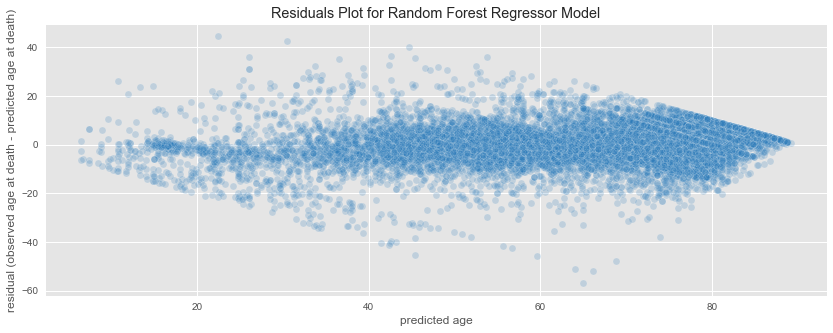

In [132]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(x=predict_train, y=(y_train - predict_train), ax=ax, alpha=0.2, color='#2b7bba');
ax.set_xlabel('predicted age')
ax.set_ylabel('residual (observed age at death - predicted age at death)')
ax.set_title('Residuals Plot for Random Forest Regressor Model')

Text(0.5, 1.0, 'Predicted v. Actual Plot for Random Forest Regressor Model, Test Set')

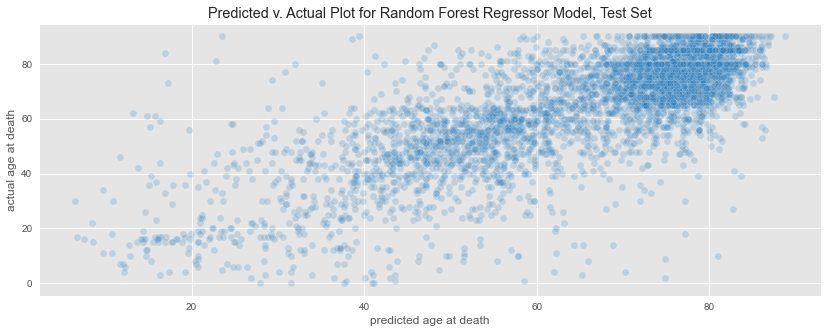

In [133]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(x=predict_test, y=y_test, ax=ax, alpha=0.2, color='#2b7bba');
ax.set_xlabel('predicted age at death')
ax.set_ylabel('actual age at death')
ax.set_title('Predicted v. Actual Plot for Random Forest Regressor Model, Test Set')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Predicted v. Actual Plot for Random Forest Regressor Model, Training Set')

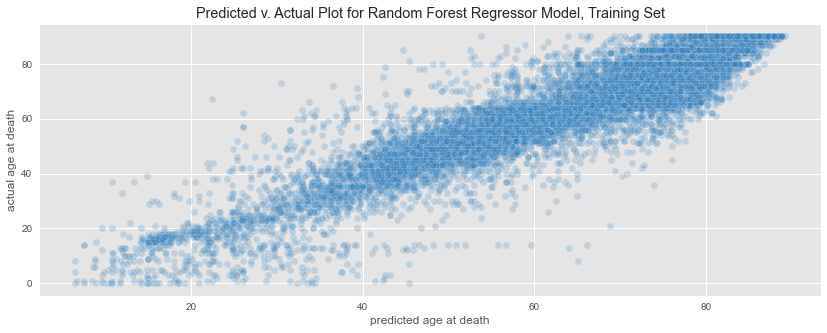

In [134]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.scatterplot(predict_train, y_train, ax=ax, alpha=0.2, color='#2b7bba');
ax.set_xlabel('predicted age at death')
ax.set_ylabel('actual age at death')
ax.set_title('Predicted v. Actual Plot for Random Forest Regressor Model, Training Set')

In [135]:
mae_train = mean_absolute_error(y_train, predict_train)
mae_test = mean_absolute_error(y_test, predict_test)
print('MAE on Training Set: ', mae_train)
print('MAE on Test Set: ', mae_test)

MAE on Training Set:  4.706525365224552
MAE on Test Set:  8.426765964056044


In [136]:
feature_importances = pd.DataFrame(model.fit(X_train, y_train).feature_importances_,
                                   index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

In [137]:
feature_importances.head(20)

,importance
hitype,0.393838
hhnum,0.155825
ms,0.152142
adjinc,0.101254
educ,0.082668
pob,0.063828
race,0.027264
sex,0.023182


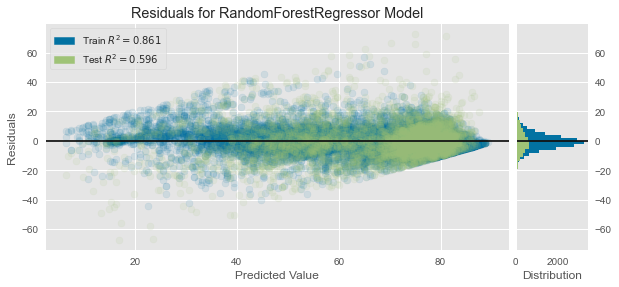

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [138]:
visualizer = ResidualsPlot(model, train_alpha=0.1, test_alpha=0.1, size=(700, 300))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()    

Predicting on User Input: 

In [139]:
cols = X_train.columns.to_list()
cols

['race', 'sex', 'ms', 'adjinc', 'educ', 'hhnum', 'pob', 'hitype']

In [140]:
sample = X_train.loc[622967]
sample

race        1.0
sex         1.0
ms          1.0
adjinc      6.0
educ        5.0
hhnum       2.0
pob       921.0
hitype      1.0
Name: 622967, dtype: float64

In [141]:
check = np.array([1, 1, 1, 6, 5, 2])
check

array([1, 1, 1, 6, 5, 2])

In [142]:
model.predict(check.reshape(1, -1))

ValueError: X has 6 features, but DecisionTreeRegressor is expecting 8 features as input.

In [143]:
joblib.dump(model, 'less_feat.pkl')


['less_feat.pkl']

In [ ]:
# some time later...

# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)

In [144]:
GBR = GradientBoostingRegressor()

In [145]:
GBR.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GradientBoostingRegressor()

In [146]:
predict_train_gbr = GBR.predict(X_train)
predict_test_gbr = GBR.predict(X_test)

In [147]:
print('MSE on Train Data with RF: ', mean_squared_error(y_train, predict_train_gbr))
print('RMSE on Train Data with RF: ', mean_squared_error(y_train, predict_train_gbr, squared=False))
print('R_squared on Train Data with RF: ', r2_score(y_train, predict_train_gbr))
print('\n')
print('MSE on Test Data with RF: ', mean_squared_error(y_test, predict_test_gbr))
print('RMSE on Test Data with RF: ', mean_squared_error(y_test, predict_test_gbr, squared=False))
print('R_squared on Train Data with RF: ', r2_score(y_test, predict_test_gbr))

MSE on Train Data with RF:  138.5139380829712
RMSE on Train Data with RF:  11.769194453443752
R_squared on Train Data with RF:  0.5643675654956257


MSE on Test Data with RF:  152.54616999396364
RMSE on Test Data with RF:  12.350958262173977
R_squared on Train Data with RF:  0.5566690024869015


In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)


In [148]:
RF = RandomForestRegressor()

In [217]:
param_grid = { 
    'n_estimators': [200, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10, 20, 30, 100]
}

In [218]:
CV_rf = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5)

In [219]:
CV_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 300, 500]})

In [220]:
CV_rf.best_params_

{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}

In [228]:
rf_final = RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=300)

In [229]:
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=300)

In [233]:
train_predictions = rf_final.predict(X_train)

In [234]:
test_predictions = rf_final.predict(X_test)

In [235]:
print('MSE on Train Data with RF: ', mean_squared_error(y_train, train_predictions))
print('RMSE on Train Data with RF: ', mean_squared_error(y_train, train_predictions, squared=False))
print('R_squared on Train Data with RF: ', r2_score(y_train, train_predictions))
print('\n')
print('MSE on Test Data with RF: ', mean_squared_error(y_test, test_predictions))
print('RMSE on Test Data with RF: ', mean_squared_error(y_test, test_predictions, squared=False))
print('R_squared on Train Data with RF: ', r2_score(y_test, test_predictions))

MSE on Train Data with RF:  121.16917228626598
RMSE on Train Data with RF:  11.007686963493555
R_squared on Train Data with RF:  0.6189176176744962


MSE on Test Data with RF:  152.25731873907756
RMSE on Test Data with RF:  12.339259245962763
R_squared on Train Data with RF:  0.5575084645000522
